Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
/content/drive/MyDrive/GitHub/master-thesis


In [2]:
%cd ..

/home/anuar/PycharmProjects/master-thesis


In [3]:
#%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
#sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')
#sys.path.append('/home/anuar/PycharmProjects/master-thesis')

from model.modeloptimization import bij_transform, bij_transform_inv, calc_mse, calc_random_walk_loss, calc_prior_loss
from model.modelinitialisierung import initialize_observations, initialize_epsilon
from model.modelcore import epid_model

## Optimization Settings

In [4]:
start_time='2020-02-26'
end_time='2021-01-31'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

dtype = torch.float32
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Initialize Observations

In [5]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
observed = torch.tensor(df_obs['Confirmed_cases'], requires_grad=False, device=device, dtype=dtype)
df_obs.head(3)

,Date,Confirmed_cases,Admissions_hospital
0,2020-02-26,1,0
1,2020-02-27,1,0
2,2020-02-28,1,0


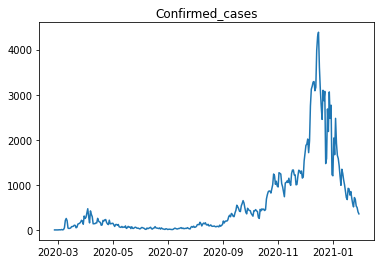

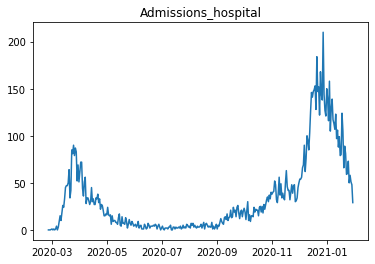

In [6]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [7]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [7]:
"""R0_lower, R0_upper = 2, 5
phi_lower, phi_upper = 0, 50
sigma_lower, sigma_upper = 0.00001, 0.5
alpha_lower, alpha_upper = 0.001, 0.05"""

'R0_lower, R0_upper = 2, 5\nphi_lower, phi_upper = 0, 50\nsigma_lower, sigma_upper = 0.00001, 0.5\nalpha_lower, alpha_upper = 0.001, 0.05'

In [8]:
"""R0_prime = bij_transform_inv(torch.tensor(3.6, device=device, dtype=dtype), R0_lower, R0_upper).detach().clone().requires_grad_(True)
phi_prime = bij_transform_inv(torch.tensor(25, device=device, dtype=dtype), phi_lower, phi_upper).detach().clone().requires_grad_(True)
sigma_prime = bij_transform_inv(torch.tensor(0.1, device=device, dtype=dtype), sigma_lower, sigma_upper).detach().clone().requires_grad_(True)
alpha_prime = bij_transform_inv(torch.tensor(0.01, device=device, dtype=dtype), alpha_lower, alpha_upper).detach().clone().requires_grad_(True)

sigma = bij_transform(sigma_prime, sigma_lower, sigma_upper)"""

'R0_prime = bij_transform_inv(torch.tensor(3.6, device=device, dtype=dtype), R0_lower, R0_upper).detach().clone().requires_grad_(True)\nphi_prime = bij_transform_inv(torch.tensor(25, device=device, dtype=dtype), phi_lower, phi_upper).detach().clone().requires_grad_(True)\nsigma_prime = bij_transform_inv(torch.tensor(0.1, device=device, dtype=dtype), sigma_lower, sigma_upper).detach().clone().requires_grad_(True)\nalpha_prime = bij_transform_inv(torch.tensor(0.01, device=device, dtype=dtype), alpha_lower, alpha_upper).detach().clone().requires_grad_(True)\n\nsigma = bij_transform(sigma_prime, sigma_lower, sigma_upper)'

In [8]:
alpha_lower, alpha_upper = 0.001, 0.05
alpha_prime = bij_transform_inv(torch.tensor(0.01, device=device, dtype=dtype), alpha_lower, alpha_upper).detach().clone().requires_grad_(True)

In [9]:
sigma_lower, sigma_upper = 0.00001, 0.5
sigma_prime = bij_transform_inv(torch.tensor(0.1, device=device, dtype=dtype), sigma_lower, sigma_upper).detach().clone().requires_grad_(True)
sigma = bij_transform(sigma_prime, sigma_lower, sigma_upper)
epsilon_t = initialize_epsilon(num_observations, sigma, device, dtype)

# Optimization

## Training

In [10]:
epochs = 1000
params = [epsilon_t]

optimizer = optim.Adam(params, lr=0.01, weight_decay=1e-8)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # forward pass
  alpha = bij_transform(alpha_prime, alpha_lower, alpha_upper)
  expected = epid_model(population, R=torch.abs(epsilon_t), initial_newly_infected=np.arange(1, 18, 3), alpha=alpha, device=device, dtype=dtype)['newly_infected']

  # calc loss
  loss = calc_mse(expected, observed)

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')


Step: 0, Time: 0.13912081718444824, Loss: 51035260.0, Mean Expected Daily Hospit: 1290.8699951171875
Step: 5, Time: 0.2756462097167969, Loss: 1542461.375, Mean Expected Daily Hospit: 147.0500030517578
Step: 10, Time: 0.1964714527130127, Loss: 1054240.5, Mean Expected Daily Hospit: 49.26520538330078
Step: 15, Time: 0.16374540328979492, Loss: 1028269.375, Mean Expected Daily Hospit: 27.295930862426758
Step: 20, Time: 0.1448218822479248, Loss: 1026446.0, Mean Expected Daily Hospit: 19.12982177734375
Step: 25, Time: 0.15630483627319336, Loss: 1027044.8125, Mean Expected Daily Hospit: 15.323984146118164
Step: 30, Time: 0.1574234962463379, Loss: 1027725.125, Mean Expected Daily Hospit: 13.332612037658691
Step: 35, Time: 0.1407473087310791, Loss: 1028214.25, Mean Expected Daily Hospit: 12.221484184265137
Step: 40, Time: 0.1427311897277832, Loss: 1028532.5625, Mean Expected Daily Hospit: 11.579477310180664
Step: 45, Time: 0.13556385040283203, Loss: 1028731.375, Mean Expected Daily Hospit: 11.2

# Evaluation

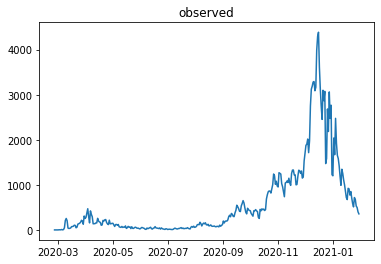

In [11]:
plt.plot(df_obs['Date'], observed.cpu().detach().numpy())
plt.title('observed')
plt.show()

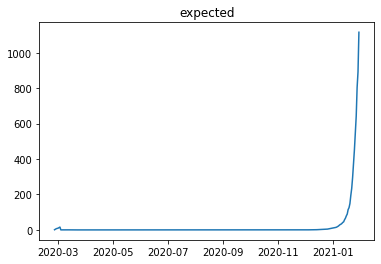

In [14]:
plt.plot(df_obs['Date'], expected.cpu().detach().numpy())
plt.title('expected')
plt.show()

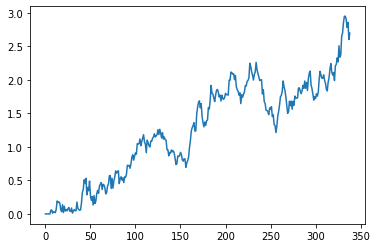

In [13]:
plt.plot(np.abs(epsilon_t.detach().numpy()))

In [45]:
alpha

tensor(0.0100, grad_fn=<AddBackward0>)